# iSens Lab: Step-CW Radar Data Processing (Sean Yao)

### 1. Import Necessary Librarys

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.constants import c
from math import ceil, log
from matplotlib.widgets import Slider, Button

### 2. Load Parameters

In [2]:
# Compute necessary values
BW = 7e9
Rres = c/(2*BW)
Rmax = 75*c/BW
print('Current Radar Setup:')
print(f"Range Resolution = {Rres} m")
print(f"Maximum Range = {Rmax} m")

Current Radar Setup:
Range Resolution = 0.021413747 m
Maximum Range = 3.21206205 m


In [3]:
# load setup parameters
freq = np.load('./constants/freq.npy')
nframes = np.load('./constants/nframes.npy')
TxRxPairs = np.load('./constants/TxRxPairs.npy')

Nfft = 2**(ceil(log(freq.shape[0],2))+1)
Ts = 1/Nfft/(freq[1]-freq[0]+1e-16) # Avoid nan checks
time_vec = np.linspace(0,Ts*(Nfft-1),num=Nfft)
dist_vec = time_vec*(c/2) # distance in meters
N_freq = freq.shape[0]


print(f'Freq Points: {freq.shape[0]} ')
print(f'TxRxPairs Shape: {TxRxPairs.shape}')
print(f'Nfft = {Nfft}')
print(f'Number of Recorded Frames: {nframes}')

Freq Points: 150 
TxRxPairs Shape: (400, 2)
Nfft = 512
Number of Recorded Frames: 100


### 3. Load Data

In [4]:
def load_data(scenario='z'):
    # specify data path components
    case = 'test/'
    data_path = './data/' + case

    if scenario == 'z':
        raw_data = 'move_z/recording.npy'
        cal_data = 'move_z/calibration.npy'

        # combine data paths
        raw_path = data_path + raw_data
        cal_path = data_path + cal_data
        # processed_path = data_path + processed_data

        # load data
        print('Current scenario: move in z direction')
        print('')
        recArr = np.load(raw_path)
        calArr = np.load(cal_path)
        print(f'z_calArr Shape: {calArr.shape}')
        print(f'z_recArr Shape: {recArr.shape}')
        print('')
        print('recArr Channels: (frame, Tx*Rx, freqs)')

    elif scenario == 'x':
        raw_data = 'move_x/recording.npy'
        cal_data = 'move_x/calibration.npy'

        # combine data paths
        raw_path = data_path + raw_data
        cal_path = data_path + cal_data
        # processed_path = data_path + processed_data

        # load data
        print('Current scenario: move in x direction')
        print('')
        recArr = np.load(raw_path)
        calArr = np.load(cal_path)
        print(f'x_calArr Shape: {calArr.shape}')
        print(f'x_recArr Shape: {recArr.shape}')
        print('')
        print('recArr Channels: (frame, Tx*Rx, freqs)')

    elif scenario == 'y':
        raw_data = 'move_y/recording.npy'
        cal_data = 'move_y/calibration.npy'

        # combine data paths
        raw_path = data_path + raw_data
        cal_path = data_path + cal_data
        # processed_path = data_path + processed_data

        # load data
        print('Current scenario: move in y direction')
        print('')
        recArr = np.load(raw_path)
        calArr = np.load(cal_path)
        print(f'y_calArr Shape: {calArr.shape}')
        print(f'y_recArr Shape: {recArr.shape}')
        print('')
        print('recArr Channels: (frame, Tx*Rx, freqs)')

    else:
        print(f'Scenario: {scenario} does not exist!')
    
    return calArr, recArr

# test
y_calArr, y_recArr = load_data(scenario='y')

Current scenario: move in y direction

y_calArr Shape: (10, 400, 150)
y_recArr Shape: (100, 400, 150)

recArr Channels: (frame, Tx*Rx, freqs)


### 4. ToF, AoA, AoD

In [5]:
def calibration(calArr, recArr):
    calFrame = np.mean(calArr,axis=0)
    return recArr - calFrame

def normalization(x):
    return (x - np.min(x))/(np.max(x)-np.min(x))

def compute_tof(X, Nfft=512):
    x = np.fft.ifft(X,Nfft,1)
    return np.linalg.norm(x,axis=0)

def compute_aoa(X, tx=0, Nfft=512):
    x = np.fft.ifft(X,Nfft,2).reshape(100,20,20,-1)
    aoa = np.fft.fft(x[:,tx,:,:],Nfft,axis=1)
    return aoa

def compute_aod(X, rx=0, Nfft=512):
    x = np.fft.ifft(X,Nfft,2).reshape(100,20,20,-1)
    aoa = np.fft.fft(x[:,:,rx,:],Nfft,axis=1)
    return aoa


### 5. 2D Plots

In [6]:
def heatmap_2D(arr, fnum):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(np.abs(arr[fnum].T),origin='lower', interpolation='none')
    ax.set_title("2-D Heat Map")
    ax.set_xlabel("Angle [deg]")
    ax.set_ylabel("Range [m]")
    ax.set_xticks(np.arange((arr[fnum].T).shape[1]),np.round(np.linspace(0,181,512),0))
    plt.locator_params(axis='x', nbins=6)
    ax.set_yticks(np.arange((arr[fnum].T).shape[0]),np.round(dist_vec,2))
    plt.locator_params(axis='y', nbins=6)

def interactive_heatmap_2d(arr):
    init_fnum = 0
    cur_frame = np.abs(arr[init_fnum].T)
    fig, ax = plt.subplots(figsize=(8,8))
    plt.ion()
    img = ax.imshow(np.abs(arr[init_fnum].T),origin='lower', interpolation='none')
    ax.set_title("2-D Heat Map")
    ax.set_xlabel("Angle [deg]")
    ax.set_ylabel("Range [m]")
    ax.set_xticks(np.arange((arr[init_fnum].T).shape[1]),np.round(np.linspace(0,181,512),0))
    plt.locator_params(axis='x', nbins=6)
    ax.set_yticks(np.arange((arr[init_fnum].T).shape[0]),np.round(dist_vec,2))
    plt.locator_params(axis='y', nbins=6)
    fig.subplots_adjust(left=0.25, bottom=0.25)
    axframe = fig.add_axes([0.25, 0.1, 0.65, 0.03])
    frame_slider = Slider(
        ax=axframe,
        label='frame',
        valmin=0,
        valmax=99,
        valinit=init_fnum,
        valstep=1,
    )
    def update(val):
        img.set_data(np.abs(arr[int(frame_slider.val)].T))
        fig.canvas.draw_idle()
    frame_slider.on_changed(update)
    resetax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
    button = Button(resetax, 'Reset', hovercolor='0.975')
    def reset(event):
        frame_slider.reset()

    button.on_clicked(reset)

    plt.show()  

Current scenario: move in y direction

y_calArr Shape: (10, 400, 150)
y_recArr Shape: (100, 400, 150)

recArr Channels: (frame, Tx*Rx, freqs)


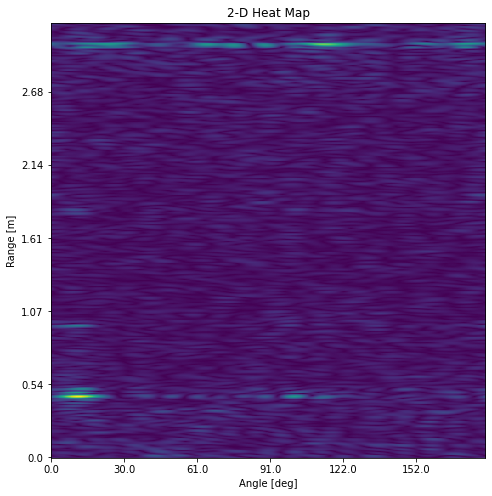

<Figure size 432x288 with 0 Axes>

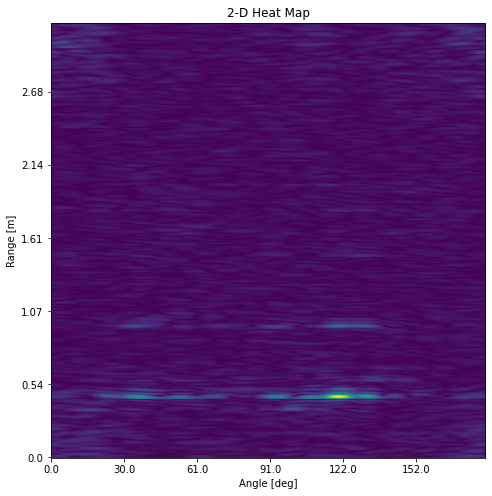

In [7]:
# Load Data
calArr, recArr = load_data(scenario='y')
# Calibrate Data
proArr = calibration(calArr,recArr)
# Compute AoA & ToF
aoaArr = compute_aoa(proArr)
# Compute AoD & ToF
aodArr = compute_aod(proArr)
# plot the first frame
heatmap_2D(aoaArr,0)
plt.figure()
heatmap_2D(aodArr,0)

In [8]:
%matplotlib inline 
%matplotlib qt

In [14]:
# Load Data
calArr, recArr = load_data(scenario='x')
# Calibrate Data
proArr = calibration(calArr,recArr)
# Compute AoA & ToF
aodArr = compute_aoa(proArr)
# plot in interactive mode
interactive_heatmap_2d(aodArr)
# plt.close()

Current scenario: move in x direction

x_calArr Shape: (10, 400, 150)
x_recArr Shape: (100, 400, 150)

recArr Channels: (frame, Tx*Rx, freqs)


In [13]:
# Load Data
calArr, recArr = load_data(scenario='y')
# Calibrate Data
proArr = calibration(calArr,recArr)
# Compute AoD & ToF
aodArr = compute_aod(proArr)
# plot the first frame
# heatmap_2D(aodArr,0)
interactive_heatmap_2d(aodArr)
plt.title('AoD 2D heatmap')
# plt.close()

Current scenario: move in y direction

y_calArr Shape: (10, 400, 150)
y_recArr Shape: (100, 400, 150)

recArr Channels: (frame, Tx*Rx, freqs)


Text(0.5, 1.0, 'AoD 2D heatmap')

In [11]:
# plt.close()